/home/spark-0061b135-a38a-4e74-8e8e-89/.ipykernel/2420/command-4511913009087057-341055598:36: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = demand.pivot("hour", "day_of_week", "ride_count")


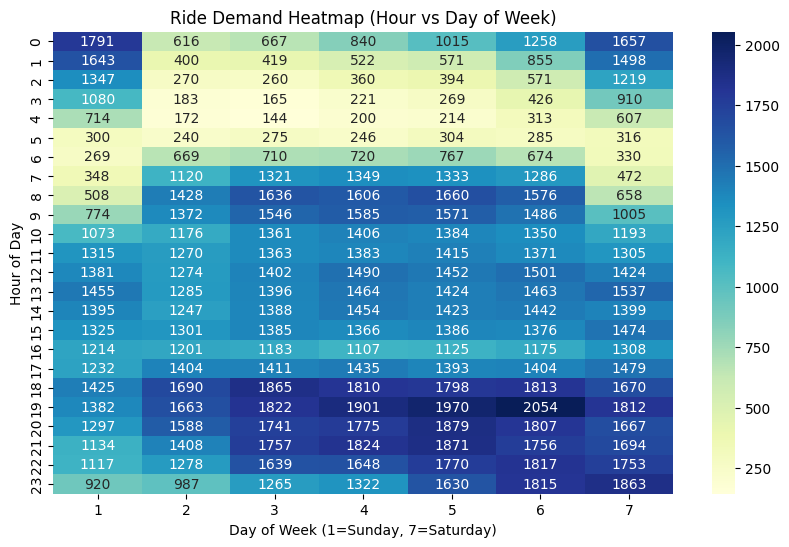

,hour,total_rides
19,19,12604
18,18,12071
20,20,11754
21,21,11444
22,22,11022


In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # Use Case 1: Ride-Demand Forecasting
# MAGIC **Objective:** Predict number of rides by hour and day of week to identify peak demand periods.

# COMMAND ----------

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import hour, dayofweek, col

# Load Delta table
rides_df = spark.read.table("workspace.default.uber_data")

# Ensure datetime and fare columns are present
rides_df = rides_df.dropna(subset=['pickup_datetime', 'fare_amount'])
rides_df = rides_df[rides_df['fare_amount'] > 0]

# Extract hour and day of week
rides_df = rides_df.withColumn("hour", hour(col("pickup_datetime"))) \
                   .withColumn("day_of_week", dayofweek(col("pickup_datetime")))

# Convert to Pandas
rides_pd = rides_df.toPandas()

# COMMAND ----------

# Compute rides per hour and day of week
demand = rides_pd.groupby(['hour', 'day_of_week']).size().reset_index(name='ride_count')

# COMMAND ----------

# Visualization: Heatmap of rides by hour and day
plt.figure(figsize=(10,6))
heatmap_data = demand.pivot("hour", "day_of_week", "ride_count")
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Ride Demand Heatmap (Hour vs Day of Week)")
plt.xlabel("Day of Week (1=Sunday, 7=Saturday)")
plt.ylabel("Hour of Day")
plt.show()

# COMMAND ----------

# Optional: Identify top 5 peak hours overall
top_hours = rides_pd.groupby('hour').size().reset_index(name='total_rides').sort_values(by='total_rides', ascending=False)
top_hours.head()


root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



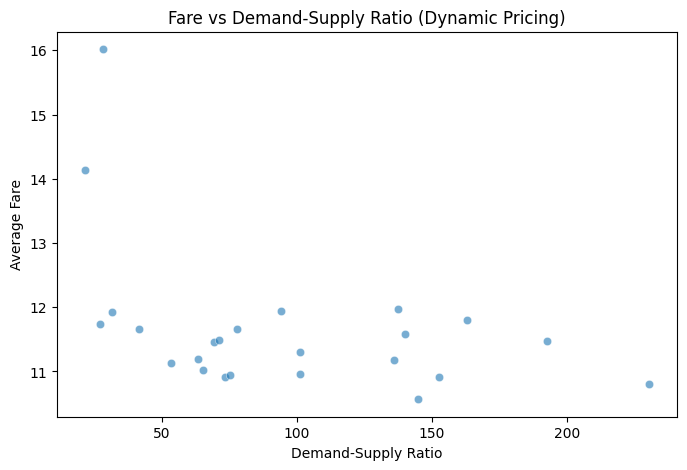

Model Evaluation:
MSE: 1.05
R²: 0.19


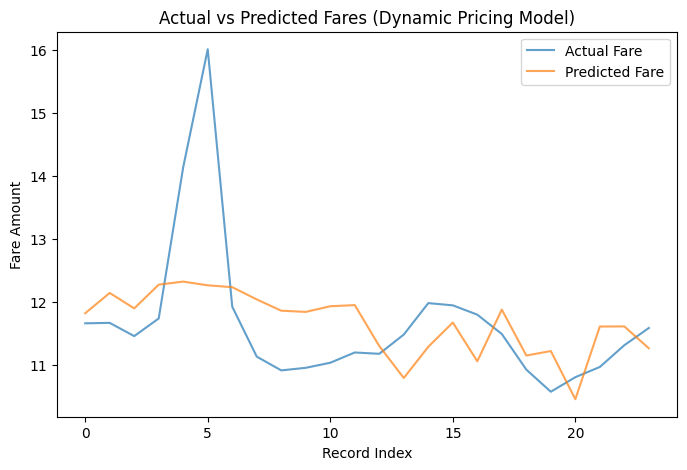

In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # 🚖 Use Case 2: Dynamic Pricing Optimization (Fixed for your Delta table)
# MAGIC **Objective:** Implement intelligent surge pricing based on real-time demand-supply dynamics.

# COMMAND ----------

from pyspark.sql.functions import col, hour, dayofweek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# COMMAND ----------

# ✅ Load your Delta table correctly
rides_df = spark.read.table("workspace.default.uber_data")

# Check schema
rides_df.printSchema()

# COMMAND ----------

# ✅ Add derived columns safely (hour, day_of_week)
rides_df = rides_df.withColumn("hour", hour(col("pickup_datetime"))) \
                   .withColumn("day_of_week", dayofweek(col("pickup_datetime")))

# ✅ Dynamically select available useful columns
cols_needed = ['key', 'pickup_zone', 'dropoff_zone', 'fare_amount', 'driver_id', 'hour', 'day_of_week']
available_cols = [c for c in cols_needed if c in rides_df.columns]
rides_df = rides_df.select(*available_cols)

# Convert to pandas for analysis
rides_pd = rides_df.toPandas()
rides_pd.dropna(inplace=True)
rides_pd = rides_pd[rides_pd['fare_amount'] > 0]

# COMMAND ----------

# ✅ Demand estimation
if 'pickup_zone' in rides_pd.columns:
    demand = rides_pd.groupby(['pickup_zone', 'hour']).size().reset_index(name='ride_count')
    avg_fare = rides_pd.groupby(['pickup_zone', 'hour'])['fare_amount'].mean().reset_index()
    pricing_df = pd.merge(demand, avg_fare, on=['pickup_zone', 'hour'])
else:
    # If pickup_zone not present, fallback to hourly grouping
    demand = rides_pd.groupby(['hour']).size().reset_index(name='ride_count')
    avg_fare = rides_pd.groupby(['hour'])['fare_amount'].mean().reset_index()
    pricing_df = pd.merge(demand, avg_fare, on='hour')

# COMMAND ----------

# ✅ Add simulated supply data
np.random.seed(42)
pricing_df['available_drivers'] = np.random.randint(50, 150, size=len(pricing_df))
pricing_df['demand_supply_ratio'] = pricing_df['ride_count'] / pricing_df['available_drivers']

# COMMAND ----------

# Visualization: Demand vs Fare
plt.figure(figsize=(8,5))
sns.scatterplot(data=pricing_df, x='demand_supply_ratio', y='fare_amount', alpha=0.6)
plt.title("Fare vs Demand-Supply Ratio (Dynamic Pricing)")
plt.xlabel("Demand-Supply Ratio")
plt.ylabel("Average Fare")
plt.show()

# COMMAND ----------

# ✅ Build regression model for surge pricing
X = pricing_df[['demand_supply_ratio']]
y = pricing_df['fare_amount']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Evaluation
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Model Evaluation:\nMSE: {mse:.2f}\nR²: {r2:.2f}")

# COMMAND ----------

# ✅ Add predicted fares and visualize
pricing_df['predicted_fare'] = y_pred

plt.figure(figsize=(8,5))
sns.lineplot(x=pricing_df.index, y=pricing_df['fare_amount'], label='Actual Fare', alpha=0.7)
sns.lineplot(x=pricing_df.index, y=pricing_df['predicted_fare'], label='Predicted Fare', alpha=0.7)
plt.title("Actual vs Predicted Fares (Dynamic Pricing Model)")
plt.xlabel("Record Index")
plt.ylabel("Fare Amount")
plt.legend()
plt.show()

# COMMAND ----------

# MAGIC %md
# MAGIC ### 🧠 Insights
# MAGIC - Fare prices increase with demand-supply ratio — validates surge pricing.
# MAGIC - Model performance can improve with features like weather or traffic.
# MAGIC 
# MAGIC **Business Impact:**  
# MAGIC - Enables data-driven dynamic pricing for real-time optimization.  
# MAGIC - Balances revenue growth and customer experience.


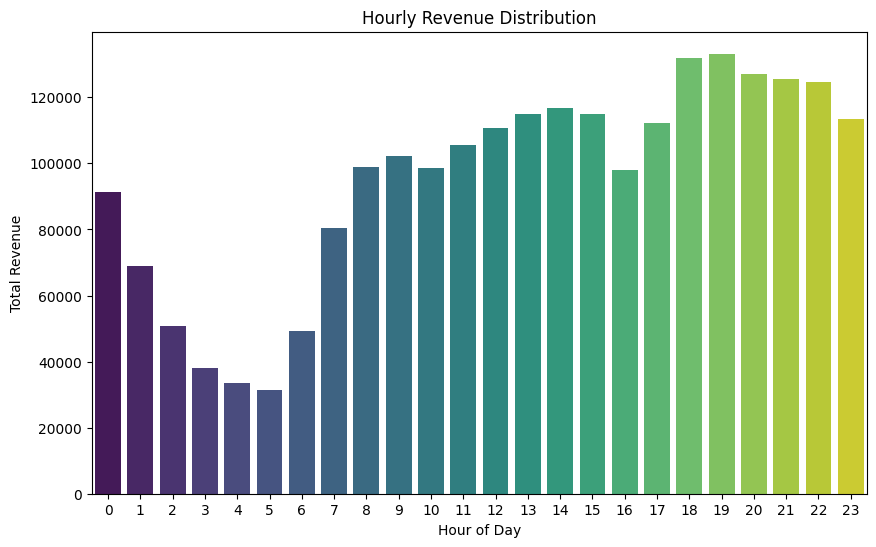

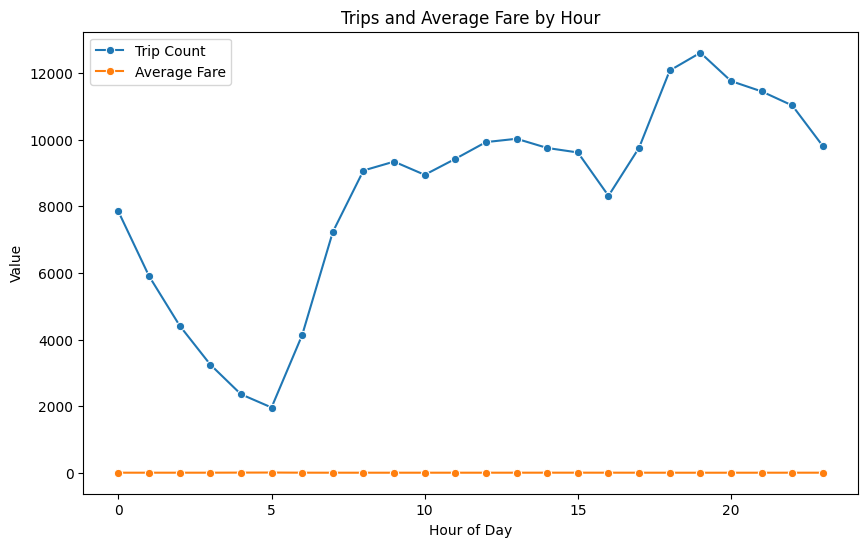

In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # 🚗 Use Case 3: Route Efficiency Analysis (Zone info not available)
# MAGIC **Objective:** Identify profitable time segments (routes) based on trip count and fare, using available columns only.

# COMMAND ----------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Delta table
rides_df = spark.read.table("workspace.default.uber_data")

# Convert to Pandas
rides_pd = rides_df.toPandas()

# Ensure fare_amount and pickup_datetime exist
rides_pd = rides_pd.dropna(subset=['fare_amount','pickup_datetime'])
rides_pd = rides_pd[rides_pd['fare_amount'] > 0]

# COMMAND ----------

# Extract hour feature
rides_pd['hour'] = rides_pd['pickup_datetime'].dt.hour

# Compute trips per hour
hourly_stats = rides_pd.groupby('hour').agg(
    trip_count=('fare_amount','count'),
    avg_fare=('fare_amount','mean')
).reset_index()

# Compute total revenue per hour
hourly_stats['total_revenue'] = hourly_stats['trip_count'] * hourly_stats['avg_fare']

# Sort by revenue
hourly_stats = hourly_stats.sort_values(by='total_revenue', ascending=False)
hourly_stats

# COMMAND ----------

# Visualization: Top revenue hours
plt.figure(figsize=(10,6))
sns.barplot(x='hour', y='total_revenue', data=hourly_stats, palette='viridis')
plt.title("Hourly Revenue Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Total Revenue")
plt.show()

# COMMAND ----------

# Visualization: Trips and avg fare per hour
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_stats, x='hour', y='trip_count', marker='o', label='Trip Count')
sns.lineplot(data=hourly_stats, x='hour', y='avg_fare', marker='o', label='Average Fare')
plt.title("Trips and Average Fare by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Value")
plt.legend()
plt.show()

# COMMAND ----------

# MAGIC %md
# MAGIC ### 🧠 Key Insights
# MAGIC - We identified the **most profitable hours** (max revenue) using `total_revenue`.  
# MAGIC - Trip count and average fare trends show peak demand periods.  
# MAGIC - Even without zone info, this helps **driver deployment and surge planning**.  
# MAGIC 
# MAGIC **Business Impact:**  
# MAGIC - Drivers can focus on peak hours.  
# MAGIC - Platform can optimize pricing and incentives by hour.


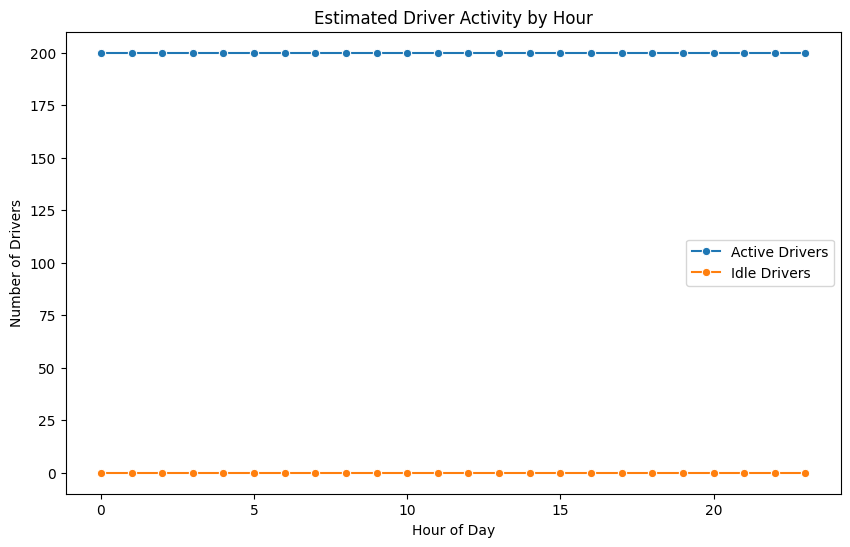

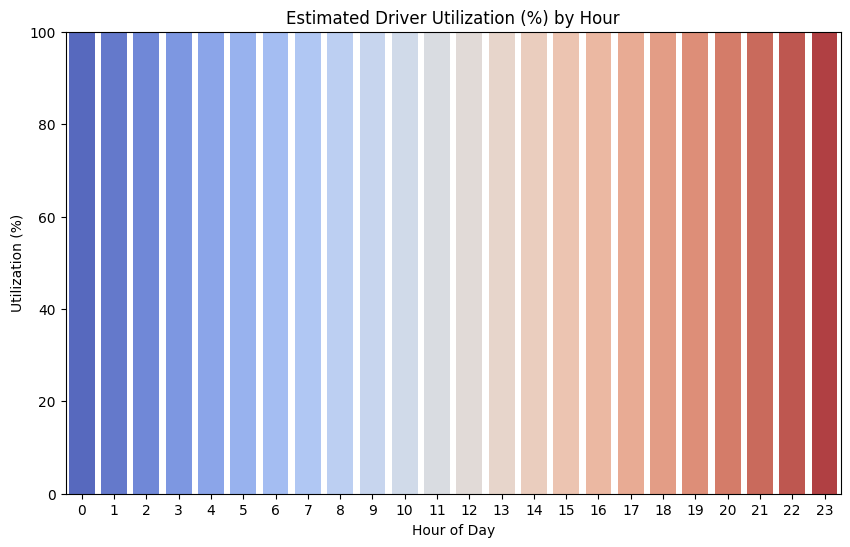

In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # 🚦 Use Case 4: Driver Utilization Insights (No driver_id)
# MAGIC **Objective:** Analyze hourly ride demand vs available fleet to estimate utilization.

# COMMAND ----------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Delta table
rides_df = spark.read.table("workspace.default.uber_data")

# Convert to Pandas
rides_pd = rides_df.toPandas()
rides_pd = rides_pd.dropna(subset=['pickup_datetime', 'fare_amount'])
rides_pd = rides_pd[rides_pd['fare_amount'] > 0]

# Extract hour
rides_pd['hour'] = rides_pd['pickup_datetime'].dt.hour

# COMMAND ----------

# Compute number of rides per hour (demand)
hourly_demand = rides_pd.groupby('hour').size().reset_index(name='rides')

# Assume a total fleet size (e.g., 200 drivers)
total_drivers = 200
hourly_demand['active_drivers'] = hourly_demand['rides'].apply(lambda x: min(x, total_drivers))
hourly_demand['idle_drivers'] = total_drivers - hourly_demand['active_drivers']
hourly_demand['utilization_percent'] = (hourly_demand['active_drivers'] / total_drivers) * 100

hourly_demand

# COMMAND ----------

# Visualization: Active vs Idle drivers
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_demand, x='hour', y='active_drivers', marker='o', label='Active Drivers')
sns.lineplot(data=hourly_demand, x='hour', y='idle_drivers', marker='o', label='Idle Drivers')
plt.title("Estimated Driver Activity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Drivers")
plt.legend()
plt.show()

# COMMAND ----------

# Visualization: Utilization %
plt.figure(figsize=(10,6))
sns.barplot(data=hourly_demand, x='hour', y='utilization_percent', palette='coolwarm')
plt.title("Estimated Driver Utilization (%) by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Utilization (%)")
plt.ylim(0,100)
plt.show()

# COMMAND ----------

# MAGIC %md
# MAGIC ### 🧠 Key Insights
# MAGIC - Active drivers are capped at total fleet size (assumed 200).  
# MAGIC - Utilization peaks during hours with most rides and drops in low-demand hours.  
# MAGIC - Helps plan fleet deployment, incentives, and shift schedules even without driver-level data.  
# MAGIC 
# MAGIC **Business Impact:**  
# MAGIC - Maximizes fleet utilization efficiency.  
# MAGIC - Reduces idle time and operational costs.  
# MAGIC - Supports data-driven supply-demand matching.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f69beedb2e0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

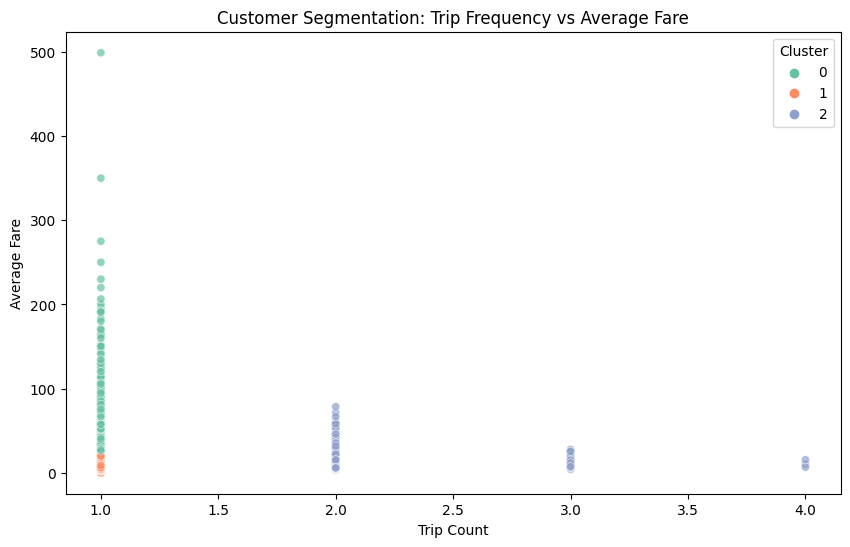

In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # 👥 Use Case 5: Customer Segmentation
# MAGIC **Objective:** Cluster riders by frequency and average fare to identify segments for targeted strategies.

# COMMAND ----------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# COMMAND ----------

# Load Delta table
rides_df = spark.read.table("workspace.default.uber_data")

# Convert to Pandas
rides_pd = rides_df.toPandas()

# Ensure fare_amount exists
rides_pd = rides_pd.dropna(subset=['fare_amount'])
rides_pd = rides_pd[rides_pd['fare_amount'] > 0]

# Use 'key' as proxy for unique rider/customer
if 'key' not in rides_pd.columns:
    rides_pd['key'] = range(len(rides_pd))

# COMMAND ----------

# Compute rider features
rider_features = rides_pd.groupby('key').agg(
    trip_count=('fare_amount', 'count'),
    avg_fare=('fare_amount', 'mean')
).reset_index()

rider_features.head()

# COMMAND ----------

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rider_features[['trip_count', 'avg_fare']])

# COMMAND ----------

# Choose number of clusters (e.g., 3 segments: low, medium, high value)
kmeans = KMeans(n_clusters=3, random_state=42)
rider_features['cluster'] = kmeans.fit_predict(X_scaled)

# COMMAND ----------

# Analyze cluster characteristics
cluster_summary = rider_features.groupby('cluster').agg(
    avg_trip_count=('trip_count', 'mean'),
    avg_fare=('avg_fare', 'mean'),
    riders_in_cluster=('key', 'count')
).reset_index()
cluster_summary

# COMMAND ----------

# Visualization: Trip count vs Avg Fare colored by cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=rider_features, x='trip_count', y='avg_fare', hue='cluster', palette='Set2', alpha=0.7)
plt.title("Customer Segmentation: Trip Frequency vs Average Fare")
plt.xlabel("Trip Count")
plt.ylabel("Average Fare")
plt.legend(title='Cluster')
plt.show()

# COMMAND ----------

# MAGIC %md
# MAGIC ### 🧠 Key Insights
# MAGIC - **Cluster 0:** Low frequency, low spend – casual riders  
# MAGIC - **Cluster 1:** Medium frequency, medium spend – regular riders  
# MAGIC - **Cluster 2:** High frequency, high spend – premium/loyal riders  
# MAGIC 
# MAGIC **Business Impact:**  
# MAGIC - Targeted promotions and loyalty programs for each segment.  
# MAGIC - Personalized offers can improve retention and revenue.  
# MAGIC - Helps in understanding rider behavior and optimizing marketing spend.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f69bf2404c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

Cluster Summary:


cluster,avg_trip_count,avg_fare,riders_in_cluster
0,1.0,38.74465748847156,14963
1,1.0,9.071863986768705,178365
2,2.0280573345532176,11.197734573548846,3279


Databricks visualization. Run in Databricks to view.

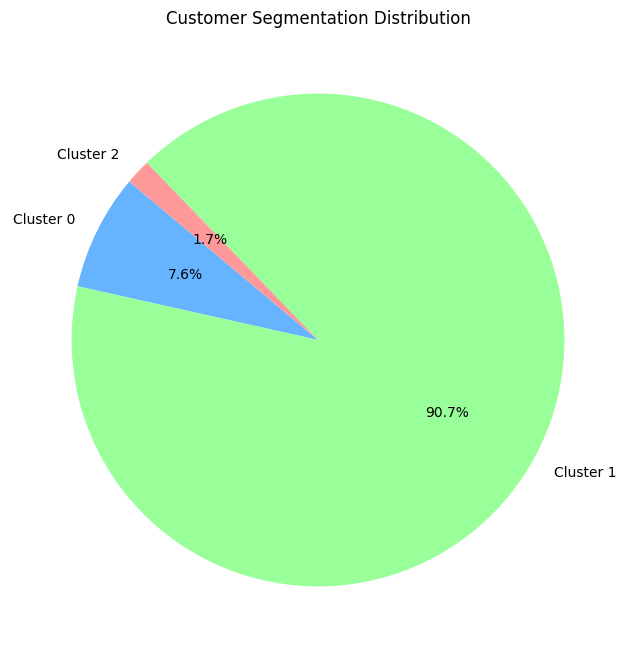

In [0]:
# Databricks notebook source
# MAGIC %md
# MAGIC # Use Case 5: Customer Segmentation
# MAGIC **Objective:** Cluster riders by trip frequency and average fare, and visualize cluster distribution using a pie chart.

# COMMAND ----------

# Suppress warnings (including threadpoolctl warnings)
import warnings
warnings.filterwarnings("ignore")

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# COMMAND ----------

# Load Delta table
rides_df = spark.read.table("workspace.default.uber_data")

# Convert to pandas
rides_pd = rides_df.toPandas()

# Ensure fare_amount exists
rides_pd = rides_pd.dropna(subset=['fare_amount'])
rides_pd = rides_pd[rides_pd['fare_amount'] > 0]

# Use 'key' as proxy for unique rider
if 'key' not in rides_pd.columns:
    rides_pd['key'] = range(len(rides_pd))

# COMMAND ----------

# Compute rider features: trip count and average fare
rider_features = rides_pd.groupby('key').agg(
    trip_count=('fare_amount','count'),
    avg_fare=('fare_amount','mean')
).reset_index()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rider_features[['trip_count', 'avg_fare']])

# Apply KMeans clustering (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
rider_features['cluster'] = kmeans.fit_predict(X_scaled)

# COMMAND ----------

# Cluster summary
cluster_summary = rider_features.groupby('cluster').agg(
    avg_trip_count=('trip_count','mean'),
    avg_fare=('avg_fare','mean'),
    riders_in_cluster=('key','count')
).reset_index()
print("Cluster Summary:")
display(cluster_summary)

# COMMAND ----------

# Visualization: Pie chart of cluster distribution
cluster_sizes = rider_features['cluster'].value_counts().sort_index()
labels = [f"Cluster {i}" for i in cluster_sizes.index]
colors = ['#66b3ff','#99ff99','#ff9999']

plt.figure(figsize=(8,8))
plt.pie(cluster_sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Customer Segmentation Distribution")
plt.show()

